# Libraries

In [2]:
import pandas as pd
import re
from scipy.sparse import csr_matrix
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns


# Dataset
### Load the datasets

In [3]:
# Paths to datasets
path = 'datasets/'

# Data types for IMDb dataset
dtype_dict = {
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': str,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': str,
    'genres': str
}

# Load the datasets
title_basics = pd.read_csv(path + 'title.basics.tsv', sep='\t', dtype=dtype_dict)
movies = pd.read_csv(path + 'ml-1m/movies.dat', sep='::', header=None, names=["MovieID","Title","Genres"], engine='python', encoding='latin1')
ratings = pd.read_csv(path + "ml-1m/ratings.dat", sep="::", header=None, names=["UserID","MovieID","Rating","Timestamp"], engine='python', encoding='latin1') 
users = pd.read_csv(path + "ml-1m/users.dat", sep="::", header=None, names=["UserID","Gender","Age","Occupation","Zip-code"], engine='python', encoding='latin1')

print("Data loaded successfully")

Data loaded successfully


### Preprocessing MovieLens data

In [4]:
def preprocess_movielens(movies):
    movies['Year'] = movies['Title'].str.extract('.*\((.*)\).*', expand=True).astype(int)
    movies['Title'] = movies['Title'].apply(lambda x: x.split('(')[0].strip()).str.lower()
    movies['Title'] = movies['Title'].apply(lambda x : x.replace("&", "and"))
    movies['Title'] = movies['Title'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    movies["TitleBase"] = movies["Title"].apply(lambda x:  "".join(x.split(", ")[0:-1]) if ", " in x else x)
    movies["Title"] = movies["Title"].apply(lambda x: x.split(", ")[-1] + " " + "".join(x.split(", ")[0:-1]) if ", " in x else x)
    movies["Title"] = movies["Title"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    movies["Title"] = movies["Title"].str.strip()
    movies["TitleBase"] = movies["TitleBase"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    movies["TitleBase"] = movies["TitleBase"].str.strip()
    return movies

movies2 = preprocess_movielens(movies)
print(f"movies2 transformed successfully. Shape: {movies2.shape}")

movies2 transformed successfully. Shape: (3883, 5)


### Preprocessing IMDb data

In [17]:
def preprocess_imdb(title_basics):
    # Remplacer les valeurs '\\N' par 0 dans la colonne startYear et convertir en entier
    title_basics.loc[title_basics['startYear'] == '\\N', 'startYear'] = 0
    title_basics['startYear'] = title_basics['startYear'].astype(int)
    
    # Convertir les colonnes en types appropriés
    title_basics['titleType'] = title_basics['titleType'].astype(str)
    title_basics['primaryTitle'] = title_basics['primaryTitle'].astype(str)
    title_basics['originalTitle'] = title_basics['originalTitle'].astype(str)
    
    # Filtrer pour ne garder que les types de titre 'movie' et 'tvMovie'
    title_basics = title_basics[title_basics['titleType'].isin(['movie', 'tvMovie'])]
    
    # Traitement sur la colonne primaryTitle
    title_basics.loc[:, 'primaryTitle'] = title_basics['primaryTitle'].apply(lambda x: x.split('(')[0].strip().lower().replace("&", "and"))
    title_basics.loc[:, 'primaryTitle'] = title_basics['primaryTitle'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    title_basics.loc[:, 'primaryTitle'] = title_basics['primaryTitle'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x)).str.strip()
    
    # Traitement sur la colonne originalTitle
    title_basics.loc[:, 'originalTitle'] = title_basics['originalTitle'].apply(lambda x: x.split('(')[0].strip().lower().replace("&", "and"))
    title_basics.loc[:, 'originalTitle'] = title_basics['originalTitle'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    title_basics.loc[:, 'originalTitle'] = title_basics['originalTitle'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x)).str.strip()
    
    return title_basics

title_basics2 = preprocess_imdb(title_basics)
print(f"title_basics2 transformed successfully. Shape: {title_basics2.shape}")


title_basics2 transformed successfully. Shape: (833594, 9)


### Merging datasets

In [6]:
def merge_datasets(movies2, title_basics2):
    movies_merged = movies2.merge(title_basics2, left_on='Title', right_on='primaryTitle', how='inner')
    movies_merged_original_title = movies2.merge(title_basics2, left_on='Title', right_on='originalTitle', how='inner')
    movies_merged_base = movies2.merge(title_basics2, left_on='TitleBase', right_on='primaryTitle', how='inner')
    movies_merged_base_original_title = movies2.merge(title_basics2, left_on='TitleBase', right_on='originalTitle', how='inner')

    movies_merged = pd.concat([movies_merged, movies_merged_original_title, movies_merged_base, movies_merged_base_original_title], ignore_index=True)
    movies_merged = movies_merged[((movies_merged["Year"] == movies_merged["startYear"] ) & (movies_merged.duplicated(subset=["Title","startYear"]))) |  (~ movies_merged.duplicated(subset=["Title","startYear"]))]
    movies_merged.drop_duplicates(subset=['Title', 'Year'], inplace=True)
    movies_merged = movies_merged.drop_duplicates(subset=['tconst'])
    
    return movies_merged

movies_merged = merge_datasets(movies2, title_basics2)
print(f"Duplicates removed. Final merged data shape: {movies_merged.shape}")


Duplicates removed. Final merged data shape: (3689, 14)


### Data Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


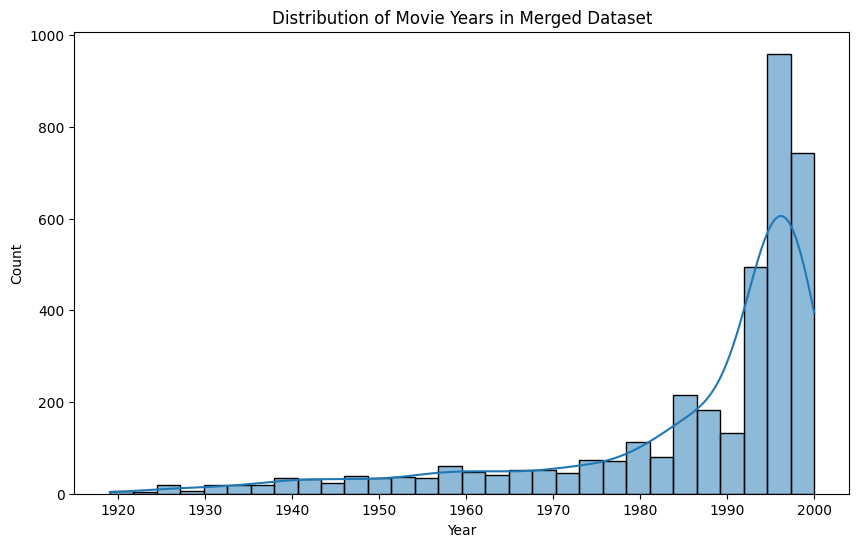

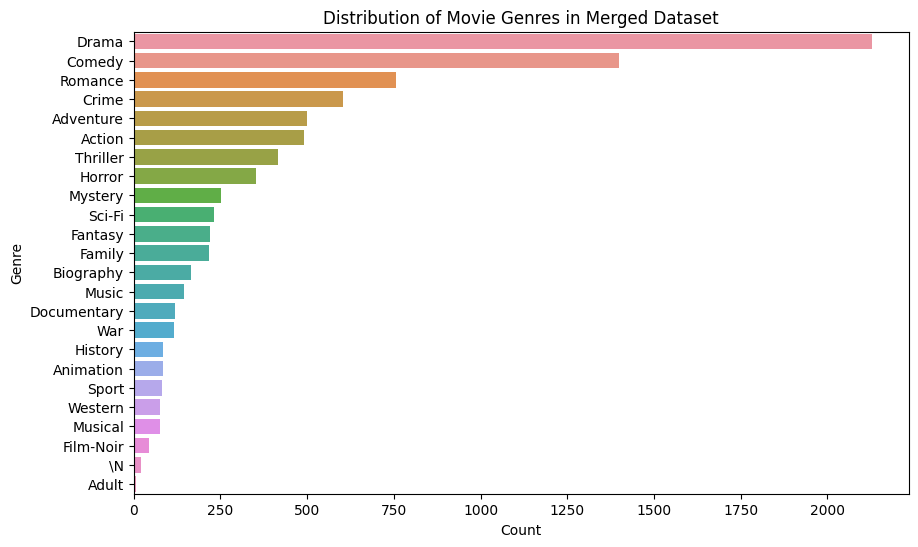

In [7]:
def visualize_data(movies_merged):
    plt.figure(figsize=(10, 6))
    sns.histplot(movies_merged['Year'], bins=30, kde=True)
    plt.title('Distribution of Movie Years in Merged Dataset')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(10, 6))
    genre_counts = movies_merged['genres'].str.get_dummies(sep=',').sum().sort_values(ascending=False)
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title('Distribution of Movie Genres in Merged Dataset')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.show()

visualize_data(movies_merged)

# Recommender System

## 1. Feature Engineering
#### We need to extract relevant features and create a user-item interaction matrix for collaborative filtering.

#### We will extract genres, directors, main actors, and movie ratings.

In [8]:
# Feature Engineering
def extract_features(movies_merged, ratings):
    genre_dummies = movies_merged['genres'].str.get_dummies(sep=',')
    movie_ratings = ratings.groupby('MovieID')['Rating'].mean().reset_index()
    movie_ratings.columns = ['MovieID', 'AvgRating']
    movies_features = movies_merged.merge(movie_ratings, on='MovieID', how='left')
    movies_features = pd.concat([movies_features, genre_dummies], axis=1)
    return movies_features

movies_features = extract_features(movies_merged, ratings)
print("Features extracted successfully. Shape:", movies_features.shape)

Features extracted successfully. Shape: (6669, 39)


In [9]:
# User-Item Matrix
def create_user_item_matrix(ratings):
    user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
    return csr_matrix(user_item_matrix.values)

user_item_matrix = create_user_item_matrix(ratings)
print("User-item matrix created successfully. Shape:", user_item_matrix.shape)


User-item matrix created successfully. Shape: (6040, 3706)


## 2. Model Development with Surprise
#### We will use matrix factorization to predict movie ratings for each user.

#### Creating the user-item matrix

In [11]:
def train_model(ratings):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    model = SVD()
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    return model, rmse

model, rmse = train_model(ratings)
print("Model trained successfully. RMSE:", rmse)

RMSE: 0.8742
Model trained successfully. RMSE: 0.8741636328359776


## 3. Recommendation Algorithm
#### We need to develop an algorithm that suggests a movie that might appeal to a couple of users using predicted ratings and complementary genres.

#### Calculating couple scores

In [12]:
def calculate_couple_score(user1, user2, model, movies_features):
    scores = []
    for movie in movies_features['MovieID'].unique():
        pred_user1 = model.predict(user1, movie).est
        pred_user2 = model.predict(user2, movie).est
        couple_score = (pred_user1 + pred_user2) / 2
        scores.append((movie, couple_score))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_10_movies = [movie for movie, score in sorted_scores[:10]]
    return top_10_movies

def recommend_movies(user1, user2, model, movies_features):
    top_movies = calculate_couple_score(user1, user2, model, movies_features)
    recommended_movies = movies_features[movies_features['MovieID'].isin(top_movies)]
    return recommended_movies

## 4. Evaluation
#### # Example of recommendation

In [13]:
user1, user2 = 1, 2
recommended_movies = recommend_movies(user1, user2, model, movies_features)
print("Recommended movies for users", user1, "and", user2, ":")
print(recommended_movies[['Title', 'AvgRating', 'genres']])

Recommended movies for users 1 and 2 :
                             Title  AvgRating                     genres
300       the shawshank redemption   4.554558                      Drama
499                schindlers list   4.510417    Biography,Drama,History
836                    rear window   4.476190           Mystery,Thriller
842               some like it hot   4.300481     Comedy,Musical,Romance
1106            lawrence of arabia   4.401925  Adventure,Biography,Drama
1147  the bridge on the river kwai   4.386994        Adventure,Drama,War
1159              the great escape   4.376437   Adventure,Drama,Thriller
2632                       sanjuro   4.608696      Action,Drama,Thriller
3158              inherit the wind   4.279851    Biography,Drama,History
3602                   sunset blvd   4.491489            Drama,Film-Noir
